# Stock Closing Price Prediction Using CNN-BiLSTM and Transformer

## Library Importing

In [738]:
# Python Standard Libraries
import os
import csv
import math
import random
import unicodedata

# Data Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP - NLTK
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM, Bidirectional,
    Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
    Flatten, GlobalAveragePooling1D, LayerNormalization,
    MultiHeadAttention, Add, Attention, Permute, Concatenate, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import Huber

# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

# Shap
import shap

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yourth/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data Importing

In [739]:
company_list = ['TSLA', 'AAPL', 'AMZN', 'GOOGL', 'MSFT']
stock_data_dict = {}

for symbol in company_list:
    path = f"./data/filtered/{symbol}_filtered.csv"
    stock_data_dict[symbol] = pd.read_csv(path)

In [740]:
TSLA = stock_data_dict['TSLA']
AAPL = stock_data_dict['AAPL']
AMZN = stock_data_dict['AMZN']
GOOGL = stock_data_dict['GOOGL']
MSFT = stock_data_dict['MSFT']

In [741]:
# df = GOOGL.copy()
# df.head()

## Temp

In [800]:
def data_integration(stock, n_past=5, n_future=1):
    df = stock_data_dict[stock]

    # 1. Data Lagging
    # Lag technical indicators to avoid leakage
    lag_cols = [
        'Adj Close', 'High', 'Low', 'Volume', 'SMA_5', 'SMA_20',
        'BB_Mid', 'BB_Std', 'BB_Upper', 'BB_Lower',
        'RSI_14', 'Log_Return', 'OBV', 'Vader_Polarity'
    ]

    for col in lag_cols:
        df[f"{col} (lag1)"] = df[col].shift(1)

    feature_cols = [
        'Adj Close',  # should be the first one for Y
        # 'Open',
        'DayOfWeek', 
        'Month',
        'Adj Close (lag1)',
        'SMA_5 (lag1)',              # short-term trend
        'Volume (lag1)',
        'BB_Mid (lag1)',           # risk signal
        'Log_Return (lag1)',
        'Vader_Polarity (lag1)'  # should be the last one for SENTIMENT
    ]

    df = df[feature_cols]

    train_size = 0.7
    train_split_idx = int(train_size * len(df))

    df_filtered = df[feature_cols]
    df_filtered = df_filtered.dropna().reset_index(drop=True)

    # df_filtered = df_filtered.iloc[1:] # delete nan ❗去掉第一天（因为 lag1 没有值）

    # 1️⃣  remove *every* row that has even one missing value
    # df_filtered = df_filtered.dropna().reset_index(drop=True)

    # Step 0: Define split boundaries BEFORE scaling
    train_df = df_filtered.iloc[:train_split_idx] # 880
    test_df  = df_filtered.iloc[train_split_idx - 5:] # 382

    print(train_df.shape, test_df.shape)

    # Step 1: Fit scaler only on training data (Avoid Data Leakage)
    scaler = MinMaxScaler()
    scaler.fit(train_df)

    # Step 2: Scale training and test data separately
    train_scaled = scaler.transform(train_df)
    test_scaled  = scaler.transform(test_df)

    # Step 3: For inference later, only scale ['Adj Close']
    scaler_for_inference = MinMaxScaler()
    actual_scaled_close = scaler_for_inference.fit_transform(
        df_filtered[['Adj Close']]
    )

    # Step 3: Reconstruct sliding windows for train and test
    def create_sequences(data, n_past, n_future):
        X, y = [], []
        for i in range(n_past, len(data) - n_future + 1): # 5 to 880-1+1=880 (actual 879)
            X.append(data[i - n_past:i, 1:]) # 5-5=0 to 5 (actually 4th) ### 879-5=874 to 879 (actual 878)
            y.append(data[i + n_future - 2:i + n_future - 1, [0]])  # Predict Adj Close  # 5+1-2=4 to 5 (actually 4th) ### 878 to 879 (actual 878)
        return np.array(X), np.array(y)

    trainX, trainY = create_sequences(train_scaled, n_past, n_future)
    testX, testY   = create_sequences(test_scaled, n_past, n_future)
    print(trainX.shape, testX.shape)


    # trainY = trainY.reshape(-1, 1)
    # testY = testY.reshape(-1, 1)

    # Without Sentiment (Baseline Model)
    trainX_wo_tweet = trainX[:, :, :-1]  # Exclude last feature
    testX_wo_tweet  = testX[:, :, :-1]
    trainY_wo_tweet = trainY
    testY_wo_tweet  = testY

    # With Sentiment (Tweet-based Model)
    trainX_with_tweet = trainX
    testX_with_tweet  = testX
    trainY_with_tweet = trainY
    testY_with_tweet  = testY

    return df_filtered, scaler, trainX, trainY, testX, testY, trainX_wo_tweet, testX_wo_tweet, trainY_wo_tweet, testY_wo_tweet, trainX_with_tweet, testX_with_tweet, trainY_with_tweet, testY_with_tweet

## Data

In [1032]:
company_list = ['TSLA', 'AAPL', 'AMZN', 'GOOGL', 'MSFT']
stock_data_dict = {}

for symbol in company_list:
    path = f"./data/filtered/{symbol}_filtered.csv"
    stock_data_dict[symbol] = pd.read_csv(path)
    
stock = 'GOOGL'

df_filtered, scaler, trainX, trainY, testX, testY, trainX_wo_tweet, testX_wo_tweet, trainY_wo_tweet, testY_wo_tweet, trainX_with_tweet, testX_with_tweet, trainY_with_tweet, testY_with_tweet = data_integration(stock=stock)

(880, 9) (382, 9)
(875, 5, 8) (377, 5, 8)


## Plotting

### 1. CNN-BiLSTM

In [996]:
def plot_metrics(model, history, X_train, y_train, X_val, y_val, sentiment_mode, stock):
    """
    显示 RMSE 和 MAE 指标，并画出训练过程中 RMSE / MAE 曲线
    """
    history_data = history.history  # 提前定义
    
    # 1. 预测
    y_train_pred = model.predict(X_train, verbose=0).squeeze()
    y_val_pred   = model.predict(X_val, verbose=0).squeeze()
    
    y_train_true = y_train.squeeze()
    y_val_true   = y_val.squeeze()
    # y_train_true = y_train.reshape(-1, 1)
    # y_val_true   = y_val.reshape(-1, 1)

    # 2. 计算指标
    train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    val_rmse   = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

    train_mae = mean_absolute_error(y_train_true, y_train_pred)
    val_mae   = mean_absolute_error(y_val_true, y_val_pred)

    title_suffix = " w/ Tweets" if sentiment_mode == "with" else "w/o Tweets"

    # 3. 打印指标
    print(f"📊 {title_suffix} RMSE: Train = {train_rmse:.4f}, Test = {val_rmse:.4f}")
    print(f"📊 {title_suffix} MAE : Train = {train_mae:.4f}, Test = {val_mae:.4f}")

    # 4. 可视化 loss 曲线
    plt.figure(figsize=(21, 9))

    # ---- Huber(0.07) subplot
    plt.subplot(1, 2, 1)
    plt.plot(history_data['loss'], label='Train Huber')
    plt.plot(history_data['val_loss'], label='Val Huber')
    plt.title(f'{stock} - Huber(0.07) {title_suffix}', fontsize=18)
    plt.xlabel('Epoch', fontsize=18); 
    plt.ylabel('Huber', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend()

    # ---- MAE subplot
    plt.subplot(1, 2, 2)
    if 'mse' in history_data:
        plt.plot(history_data['mse'], label='Train MSE')
        plt.plot(history_data['val_mse'], label='Val MSE')
    else:
        # fallback: flat line (not recommended long term)
        plt.plot([train_mae] * len(history_data['loss']), label='Train MAE (flat)')
        plt.plot([val_mae]   * len(history_data['val_loss']), label='Val MAE (flat)')
    plt.title(f'{stock} - MSE {title_suffix}', fontsize=18)
    plt.xlabel('Epoch', fontsize=18); 
    plt.ylabel('MSE', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend()

    # ✅ Add supertitle here
    plt.suptitle(f'Model Training Metrics - CNN+BiLSTM', fontsize=24)
    plt.tight_layout()
    
    plt.show()

In [835]:
# Helper Function: get predicted and true values in original (unscaled) price units
def inv_preds(model, X, y, scaler):
    # Predict using the model and reshape to [samples, output_dim]
    p = model.predict(X, verbose=0).reshape(-1, y.shape[-1])

    # Reshape ground truth to same shape for inverse transformation
    g = y.reshape(-1, y.shape[-1])

    # Apply inverse scaling to recover original price scale
    # inv_p = scaler_for_inference.inverse_transform(p)
    # inv_g = scaler_for_inference.inverse_transform(g)

    # Return only the first column ('Adj Close') from each
    # return inv_p[:, 0], inv_g[:, 0]
    
    # Use the full-feature scaler
    inv_p = scaler.inverse_transform(
        np.concatenate([p, np.zeros((p.shape[0], scaler.n_features_in_ - 1))], axis=1)
    )[:, 0]
    inv_g = scaler.inverse_transform(
        np.concatenate([g, np.zeros((g.shape[0], scaler.n_features_in_ - 1))], axis=1)
    )[:, 0]

    return inv_p, inv_g

In [836]:
def plot_pred_vs_actual(
    model, X_train, y_train, X_test, y_test, scaler,
    model_name,
    df,
    stock_name,
    sentiment_mode="without"
):
    """
    可视化训练集 + 测试集的预测值 vs 实际收盘价（带时间对齐）

    参数：
    - model：训练好的模型
    - X_train / y_train：训练数据
    - X_test / y_test：测试数据
    - all_dates：完整日期 index（如 df.index）
    - all_adj：完整实际收盘价序列（如 df['Adj Close']）
    - scaler_for_inference：用于反归一化的 scaler（必须已 fit）
    - title_prefix：图标题前缀，例如 'NFLX'
    - sentiment_mode：'with' / 'without'，决定标题和标签
    """

    # df=df[5:]

    all_dates=df.index

    all_adj=df['Adj Close']
    # Window Siz: number of lookback days
    lookback = X_train.shape[1] # 5

    # Number of training samples
    n_train  = X_train.shape[0] # 875

    # Number of testing samples
    n_test   = X_test.shape[0] # 377

    # Predictions will start from the index equal to lookback (since earlier data was used for input windows)
    pred_start = lookback - 1

    # Time indices for training predictions aligned with full date range
    train_pts = np.arange(pred_start, pred_start + n_train) # 4 to 4+875=879 (Actual 878)

    # Time indices for test predictions aligned with full date range
    test_pts  = np.arange(pred_start + n_train,
                          pred_start + n_train + n_test) # 4+875=879 to 879+377=1256  (Actual 1255)

    # Get model predictions and true values (unscaled)
    pred_close_train, _ = inv_preds(model, X_train, y_train, scaler)
    pred_close_test,  _ = inv_preds(model, X_test, y_test, scaler)

    # Set title & label based on mode
    title_suffix = f"({model_name} w/ Tweets)" if sentiment_mode == "with" else f"({model_name} w/o Tweets)"

    x = all_dates[train_pts.tolist() + test_pts.tolist()]
    y = all_adj[np.arange(pred_start, pred_start + n_train + n_test)]

    plt.figure(figsize=(18, 7))
    # sns.lineplot(x=all_dates[pred_start:], y=all_adj[pred_start:], label='Actual Closing', color='black')
    sns.lineplot(x=x, y=y, label="Actual Closing", color='black')

    sns.lineplot(x=all_dates[train_pts], y=pred_close_train, label='Train Predicted', color='red')
    sns.lineplot(x=all_dates[test_pts],  y=pred_close_test,  label='Test Predicted')
    plt.axvline(x=all_dates[train_pts[-1]], color='gray', linestyle='--', label='Train/Test Split')

    plt.title(f'{stock_name} - Closing Price vs Actual Stock {title_suffix}', fontsize=20)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Price (Dollar)', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## CNN-BiLSTM

In [1033]:
# def cnn_biLSTM(input_shape, output_dim):

#     model = Sequential()

#     model.add(Conv1D(128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
#     model.add(MaxPooling1D(pool_size=2, strides=2))

#     model.add(Conv1D(64, kernel_size=2, strides=1, padding='valid'))
#     model.add(MaxPooling1D(pool_size=1, strides=2))

#     model.add(Bidirectional(LSTM(256, return_sequences=True)))
#     model.add(Dropout(0.2))
#     model.add(Bidirectional(LSTM(256, return_sequences=True)))
#     model.add(Dropout(0.2))

#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(output_dim, activation='relu'))
#     # model.summary()
#     return model

In [1034]:
def cnn_biLSTM(input_shape, output_dim):
    inputs = Input(shape=input_shape)

    x = Conv1D(128, kernel_size=2, strides=1, padding='valid')(inputs)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Conv1D(64, kernel_size=2, strides=1, padding='valid')(x)
    x = MaxPooling1D(pool_size=1, strides=2)(x)

    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.20)(x)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.20)(x)

    # === Add attention here ===
    attn_out = Attention(use_scale=True)([x, x])  # Self-attention: query = value = key = x
    x = GlobalAveragePooling1D()(attn_out)

    x = Dense(64, activation='relu')(x)
    outputs = Dense(output_dim, activation='relu')(x)

    return Model(inputs, outputs)

In [1035]:
def cnn_biLSTM_SENT(input_shape, sentiment_index, output_dim):
    """
    Cross-attention version: BiLSTM attends to sentiment sequence separately.
    input_shape: (n_past, num_features)   e.g., (5, 9)
    sentiment_index: int, index of sentiment feature (e.g., 8)
    output_dim: usually 1
    """

    # === Input full sequence ===
    full_input = Input(shape=input_shape)

    # === Split sentiment and rest ===
    sentiment = Lambda(lambda x: tf.expand_dims(x[:, :, sentiment_index], axis=-1))(full_input)
    rest = Lambda(lambda x: tf.concat([
        x[:, :, :sentiment_index], x[:, :, sentiment_index+1:]
    ], axis=-1))(full_input)

    # === CNN + BiLSTM on main inputs ===
    x = Conv1D(128, kernel_size=2, strides=1, padding='valid')(rest)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Conv1D(128, kernel_size=2, strides=1, padding='valid')(x)
    x = MaxPooling1D(pool_size=1, strides=2)(x)

    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.2)(x)

    # === Cross-attention: query = price features, key/value = sentiment ===
    sentiment_proj = Dense(x.shape[-1])(sentiment)  # (batch, time, feature_dim)
    attended_sentiment = Attention(use_scale=True)([x, sentiment_proj])

    # === Combine attended sentiment with price path ===
    x = Concatenate()([x, attended_sentiment])
    x = GlobalAveragePooling1D()(x)

    # === Dense output ===
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(output_dim, activation='relu')(x)

    return Model(inputs=full_input, outputs=output)


In [1036]:
# Build models
cnnBiLSTM_woSent = cnn_biLSTM(
    (trainX_wo_tweet.shape[1], trainX_wo_tweet.shape[2]), trainY.shape[2]
)
cnnBiLSTM_woSent.compile(
    optimizer=Adam(learning_rate=0.001),
    # loss=integrated_loss(delta=0.1, lambda_dir=0.16),  # 👈 adjust as needed
    # loss='mse',  # 👈 adjust as needed
    loss=Huber(0.07), 
    metrics=['mse']
)


cnnBiLSTM_withSent = cnn_biLSTM(
    (trainX_with_tweet.shape[1], trainX_with_tweet.shape[2]), trainY.shape[2]
)
cnnBiLSTM_withSent.compile(
    optimizer=Adam(learning_rate=0.001),
    # loss=integrated_loss(delta=0.1, lambda_dir=0.16),  # 👈 adjust as needed
    # loss='mse',  # 👈 adjust as needed
    loss=Huber(0.07),
    metrics=['mse']
)

In [1037]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # ← good default
    patience=3,
    min_lr=1e-7,
    verbose=1
)

In [1038]:
# Fit models
history_cnnBiLSTM_woSent = cnnBiLSTM_woSent.fit(
    trainX_wo_tweet,
    trainY_wo_tweet,
    epochs=50,
    batch_size=64,
    validation_data=(testX_wo_tweet, testY_wo_tweet),  # ← use your test split here
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50


/Users/yourth/Desktop/aaa/venv/lib/python3.11/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0194 - mse: 0.1546 - val_loss: 0.0161 - val_mse: 0.0749 - learning_rate: 0.0010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0044 - mse: 0.0129 - val_loss: 0.0068 - val_mse: 0.0212 - learning_rate: 0.0010
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mse: 0.0039 - val_loss: 0.0028 - val_mse: 0.0067 - learning_rate: 0.0010
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mse: 0.0022 - val_loss: 0.0013 - val_mse: 0.0029 - learning_rate: 0.0010
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.3562e-04 - mse: 0.0018 - val_loss: 9.8202e-04 - val_mse: 0.0021 - learning_rate: 0.0010
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.5788e-04 - mse: 0.0016 - val_loss: 0.0011 - val_mse: 0.0023 - learning_rate: 0.0010
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8731e-04 - mse: 0.0012 - val_loss: 9.6089e-04 - val_mse: 0.0020 - learning_rate: 0.0010
Epoch 8/5

In [1039]:
history_cnnBiLSTM_withSent = cnnBiLSTM_withSent.fit(
    trainX_with_tweet,
    trainY_with_tweet,
    epochs=50,
    batch_size=64,
    validation_data=(testX_with_tweet, testY_with_tweet),  # ← and here
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0197 - mse: 0.1532 - val_loss: 0.0203 - val_mse: 0.1128 - learning_rate: 0.0010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063 - mse: 0.0221 - val_loss: 0.0037 - val_mse: 0.0098 - learning_rate: 0.0010
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mse: 0.0045 - val_loss: 0.0029 - val_mse: 0.0071 - learning_rate: 0.0010
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - mse: 0.0023 - val_loss: 0.0019 - val_mse: 0.0044 - learning_rate: 0.0010
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.2237e-04 - mse: 0.0018 - val_loss: 0.0011 - val_mse: 0.0022 - learning_rate: 0.0010
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6994e-04 - mse: 0.0017 - val_loss: 0.0012 - val_mse: 0.0025 - learning_rate: 0.0010
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9746e-04 - mse: 0.0015 - val_loss: 0.0016 - val_mse: 0.0035 - learning_rate: 0.0010
Epoch 8

/Users/yourth/Desktop/aaa/venv/lib/python3.11/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


📊 w/o Tweets RMSE: Train = 0.0248, Test = 0.0375
📊 w/o Tweets MAE : Train = 0.0179, Test = 0.0297


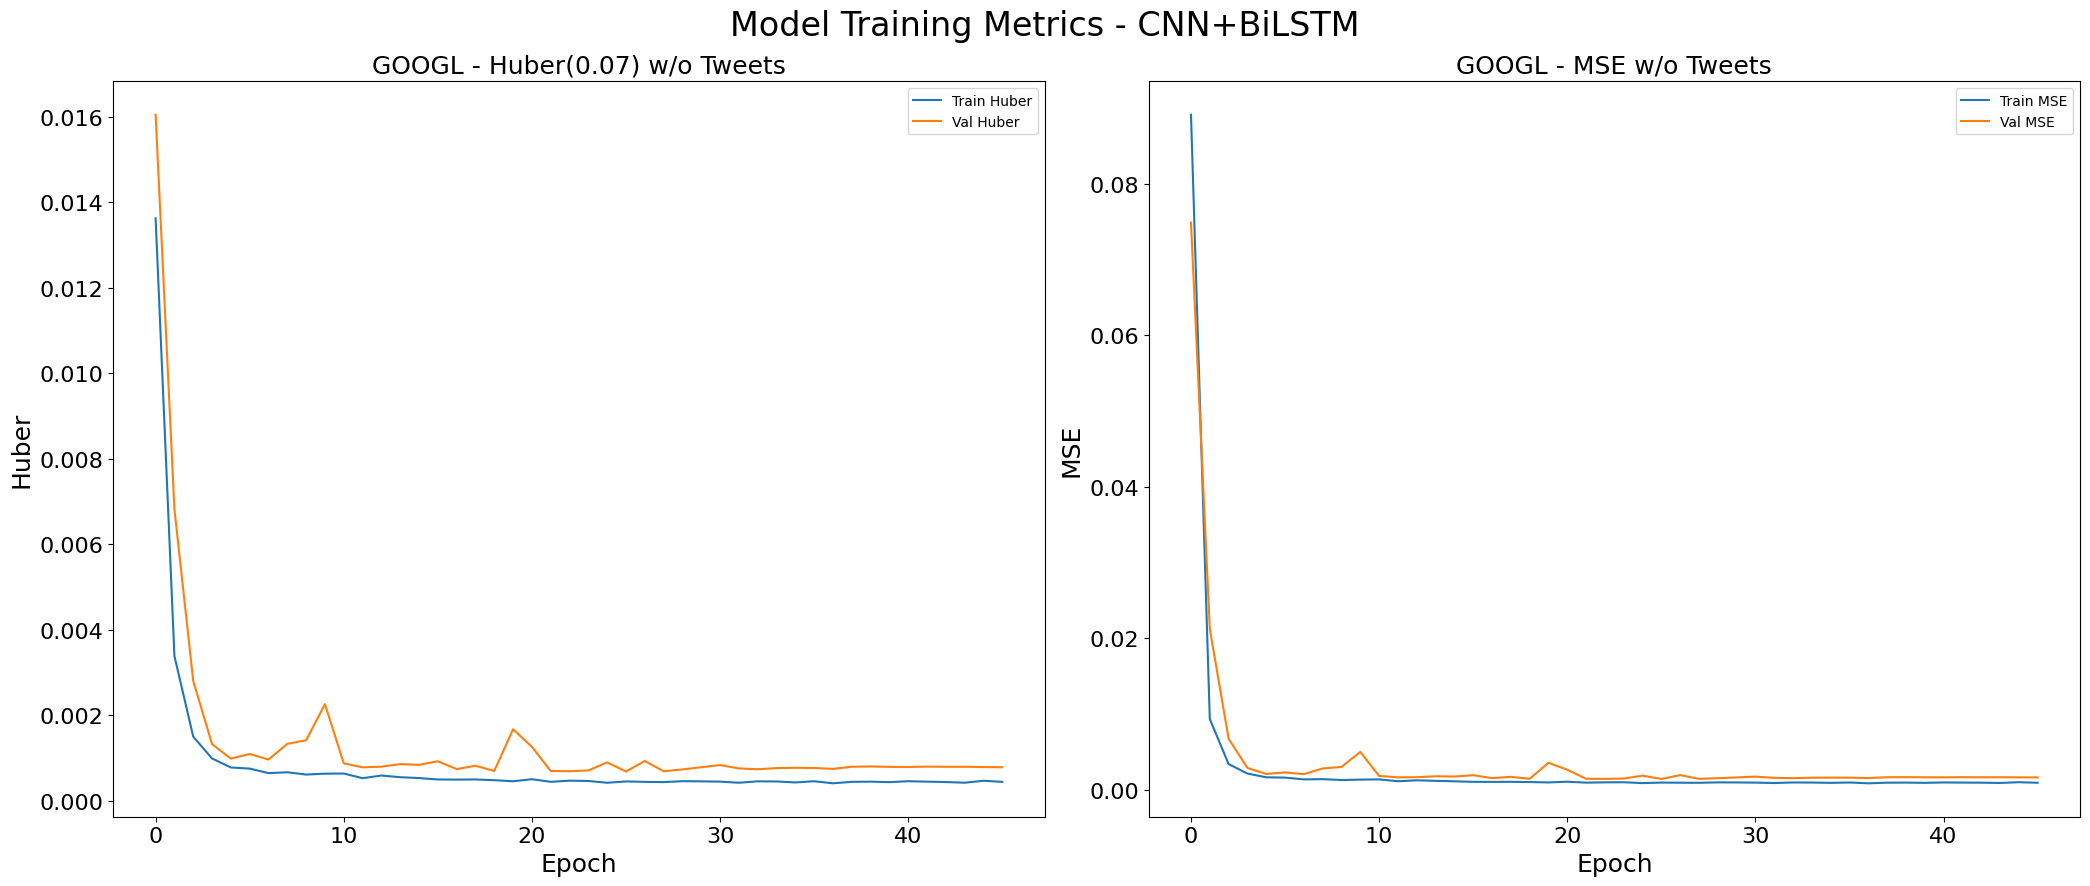

/Users/yourth/Desktop/aaa/venv/lib/python3.11/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/Users/yourth/Desktop/aaa/venv/lib/python3.11/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


📊  w/ Tweets RMSE: Train = 0.0265, Test = 0.0422
📊  w/ Tweets MAE : Train = 0.0193, Test = 0.0332


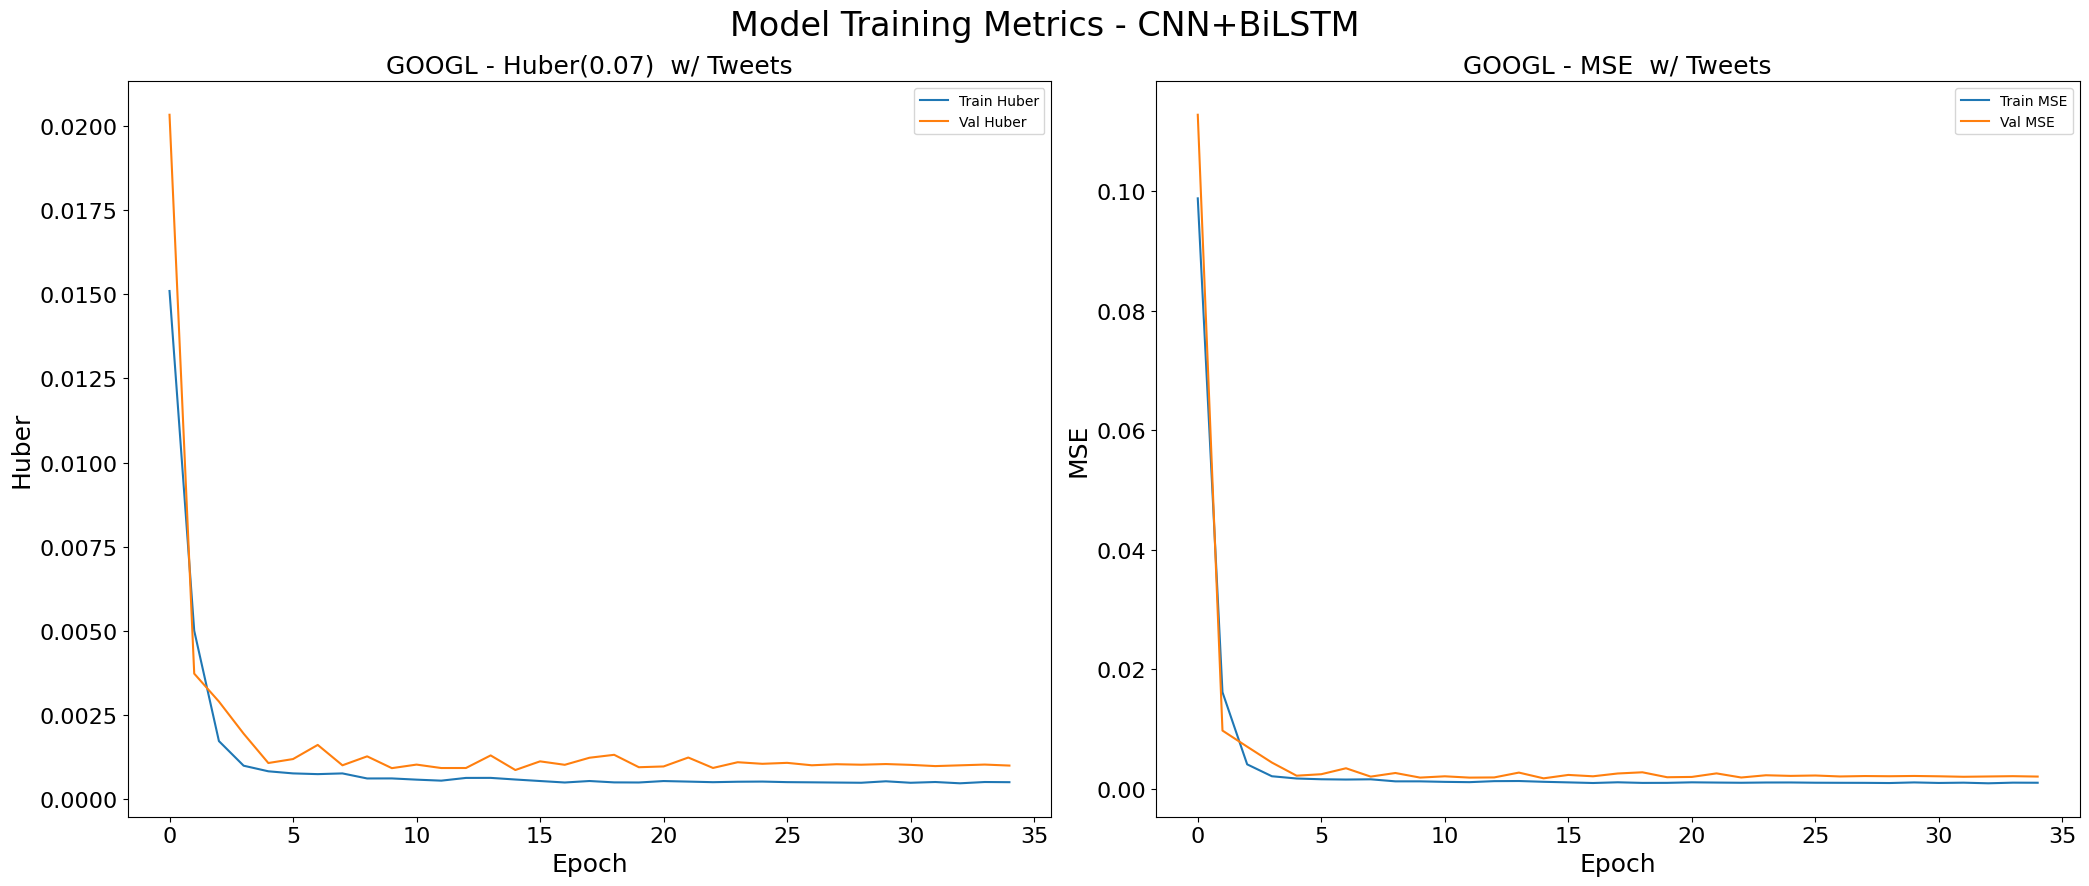

In [1040]:
plot_metrics(cnnBiLSTM_woSent, history_cnnBiLSTM_woSent,
             trainX_wo_tweet, trainY_wo_tweet,
             testX_wo_tweet, testY_wo_tweet,
             "without",
             stock=stock)

plot_metrics(cnnBiLSTM_withSent, history_cnnBiLSTM_withSent,
             trainX_with_tweet, trainY_with_tweet,
             testX_with_tweet, testY_with_tweet,
             "with",
             stock=stock)

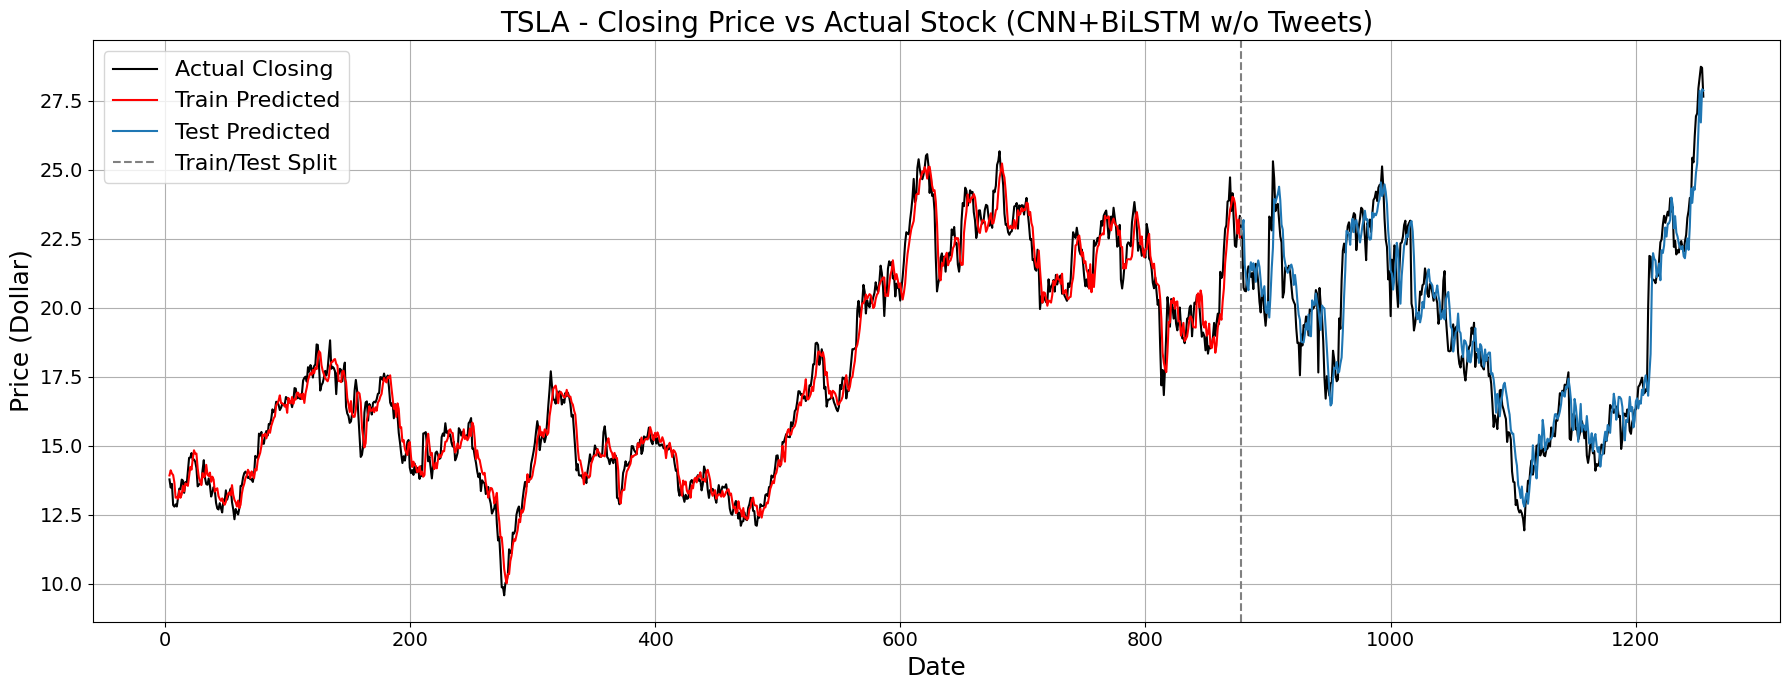

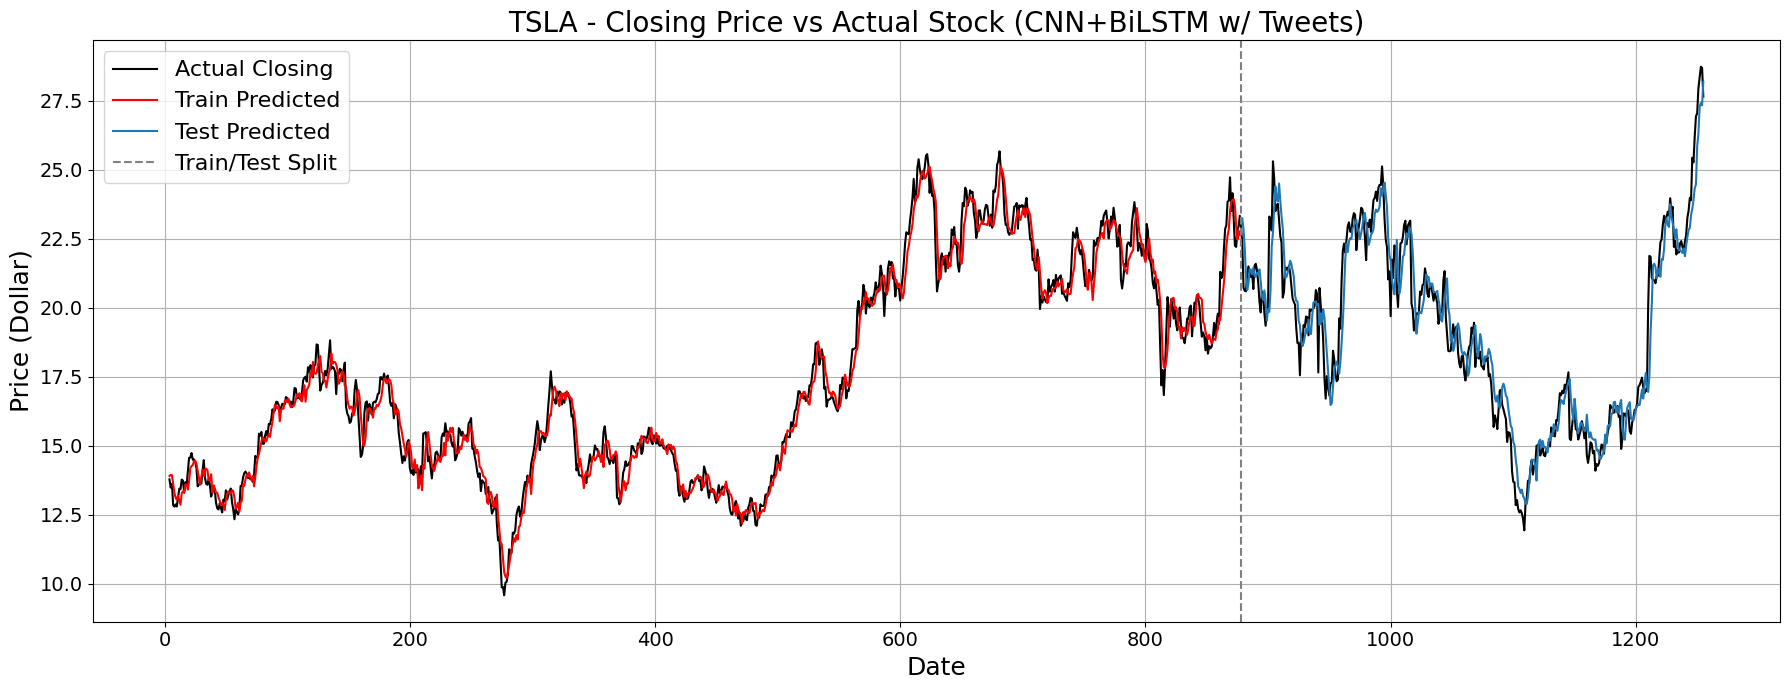

In [1017]:
plot_pred_vs_actual(
    model=cnnBiLSTM_woSent,
    X_train=trainX_wo_tweet, y_train=trainY_wo_tweet,
    X_test=testX_wo_tweet,   y_test=testY_wo_tweet,
    scaler=scaler,
    df=df_filtered,
    model_name="CNN+BiLSTM",
    stock_name=stock,
    sentiment_mode="without"
)

plot_pred_vs_actual(
    model=cnnBiLSTM_withSent,
    X_train=trainX_with_tweet, y_train=trainY_with_tweet,
    X_test=testX_with_tweet,   y_test=testY_with_tweet,
    scaler=scaler,
    df=df_filtered,
    model_name="CNN+BiLSTM",
    stock_name=stock,
    sentiment_mode="with"
)